以下の人を想定。
- 納税者本人: 障害なし、勤労学生ではない
- 配偶者: なし
- 扶養家族: なし
- 被保険者種別: 第1号被保険者
- 事業収入:
    - 営業売上: 0〜1,500,000円（10万区切りで計算）
    - 売上原価: 0円
    - 経費: 0円
- 申告年: 令和6年をベースに定額減税をなしにした設定

国民健康保険
- 加入地域: 東京都杉並区
- 介護分: 負担あり（40歳以上）

国民年金保険
- 199,490円（口座振替で1年前納）

消費税
- 課税制度: 簡易課税
- みなし仕入率: 50%

住民税
- 合計所得金額が一定金額（45万円）以下の場合は免除

In [1]:
import os
import sys

import pandas as pd

pd.set_option("display.max_rows", None)

sys.path.append(os.path.join(os.getcwd(), '..', 'lib'))

from const.所得税_基礎控除_R2 import 所得税_基礎控除_R2
from const.所得税_税率_H27 import 所得税_税率_H27
from const.給与所得控除_R2 import 給与所得控除_R2
from const.国民健康保険_R6 import 国民健康保険_R6
from const.住民税_基礎控除_R3 import 住民税_基礎控除_R3
from const.住民税_税率一覧_R7 import 住民税_税率一覧_R7
from context import create_context

from 所得.事業所得 import 損益計算書
from 所得税及び復興特別所得税の申告内容確認表 import 所得税及び復興特別所得税の申告内容確認表_第一表, 所得金額等
from 国民健康保険 import 国民健康保険
from 住民税 import 住民税
from 納税者 import 納税者

from 消費税及び地方消費税.共通.課税売上高計算表 import 課税売上高計算表
from 消費税及び地方消費税.簡易課税.控除対象仕入税額等の計算表_1種類の事業の専業者 import 控除対象仕入税額等の計算表_1種類の事業の専業者
from 消費税及び地方消費税.簡易課税.税率別消費税額計算表 import 税率別消費税額計算表, みなし仕入率_サービス業等
from 消費税及び地方消費税.共通.消費税及び地方消費税の申告書_第二表 import 消費税及び地方消費税の申告書_第二表
from 消費税及び地方消費税.簡易課税.消費税及び地方消費税の申告書_第一表 import 消費税及び地方消費税の申告書_第一表

In [2]:
"""
設定項目 年に対する定数
"""
# 2024年(R6)
context = create_context()
context.給与所得控除 = 給与所得控除_R2()
context.所得税_基礎控除 = 所得税_基礎控除_R2()
context.所得税_税率 = 所得税_税率_H27()
context.住民税_基礎控除 = 住民税_基礎控除_R3()
context.住民税_税率一覧 = 住民税_税率一覧_R7()
context.国民健康保険 = 国民健康保険_R6()

In [3]:
"""
設定項目 納税者情報
"""
# 納税者
# 年齢によって国民健康保険の介護分の有無が変わる
# 国民健康保険の加入地域によって保険料率が変わる
x納税者 = 納税者()
x納税者.納税者本人.年齢 = 40
x納税者.国民健康保険_加入地域 = '東京都杉並区'

# 業種によって消費税が変わる
xみなし仕入率 = みなし仕入率_サービス業等

In [4]:
def 年収内訳(x納税者: 納税者, 収入金額: int) -> pd.Series:
    # 所得
    x損益計算書 = 損益計算書(収入金額)
    x所得金額等 = 所得金額等(事業_営業等=x損益計算書)

    # 国民健康保険、国民年金保険
    x国民健康保険 = 国民健康保険(x所得金額等, x納税者)
    # 国民健康保険_dic = x国民健康保険.区分別保険料
    国民健康保険_i = x国民健康保険.保険料
    国民年金保険_i = 199_490
    x納税者.社会保険料 = 国民健康保険_i + 国民年金保険_i

    # 所得税
    x所得税及び復興特別所得税の申告内容確認表_第一表 = 所得税及び復興特別所得税の申告内容確認表_第一表(所得金額等=x所得金額等, 納税者=x納税者)
    所得税_i = x所得税及び復興特別所得税の申告内容確認表_第一表.所得税_税額控除.申告納税額

    # 消費税
    x課税売上高計算表 = 課税売上高計算表()
    x課税売上高計算表.うち標準税率7_8per適用分.事業所得に係る課税売上高_営業等課税売上高 = x損益計算書.売上金額
    x控除対象仕入税額等の計算表 = 控除対象仕入税額等の計算表_1種類の事業の専業者(みなし仕入率=xみなし仕入率)
    x税率別消費税額計算表 = 税率別消費税額計算表(課税売上高計算表=x課税売上高計算表, 控除対象仕入税額等の計算表=x控除対象仕入税額等の計算表)
    x消費税及び地方消費税の申告書_第二表 = 消費税及び地方消費税の申告書_第二表(税率別消費税額計算表=x税率別消費税額計算表)
    x消費税及び地方消費税の申告書_第一表 = 消費税及び地方消費税の申告書_第一表(消費税及び地方消費税の申告書_第二表=x消費税及び地方消費税の申告書_第二表)
    消費税_i = x消費税及び地方消費税の申告書_第一表.消費税及び地方消費税の合計税額

    # 住民税
    # 前年中の合計所得金額が一定金額以下の場合は免除
    # 扶養家族（同一生計対象配偶者または扶養親族）がいない場合は45万円
    if x所得金額等.合計所得金額>450_000:
        x住民税 = 住民税(所得税_所得控除=x所得税及び復興特別所得税の申告内容確認表_第一表.所得税_所得控除, 納税者=x納税者)
        住民税_i = x住民税.年税額
    else:
        住民税_i = 0

    # 手取り
    手取り_i = 収入金額 - x納税者.社会保険料 - 所得税_i - 消費税_i - 住民税_i

    return pd.Series({
        '年収': 収入金額,
        '国民健康保険': 国民健康保険_i,
        # **国民健康保険_dic,
        '国民年金保険': 国民年金保険_i,
        '国民年金保険内訳': x国民健康保険.to_dataframe(),
        '所得税': 所得税_i,
        '消費税': 消費税_i,
        '住民税': 住民税_i,
        '手取り': 手取り_i,
    })

In [5]:
年収内訳df = pd.DataFrame()
年収range = range(0, 15_000_001, 100_000)
for i in 年収range:
    ser = 年収内訳(x納税者, i)
    年収内訳df = pd.concat([年収内訳df, pd.DataFrame([ser])], ignore_index=True)

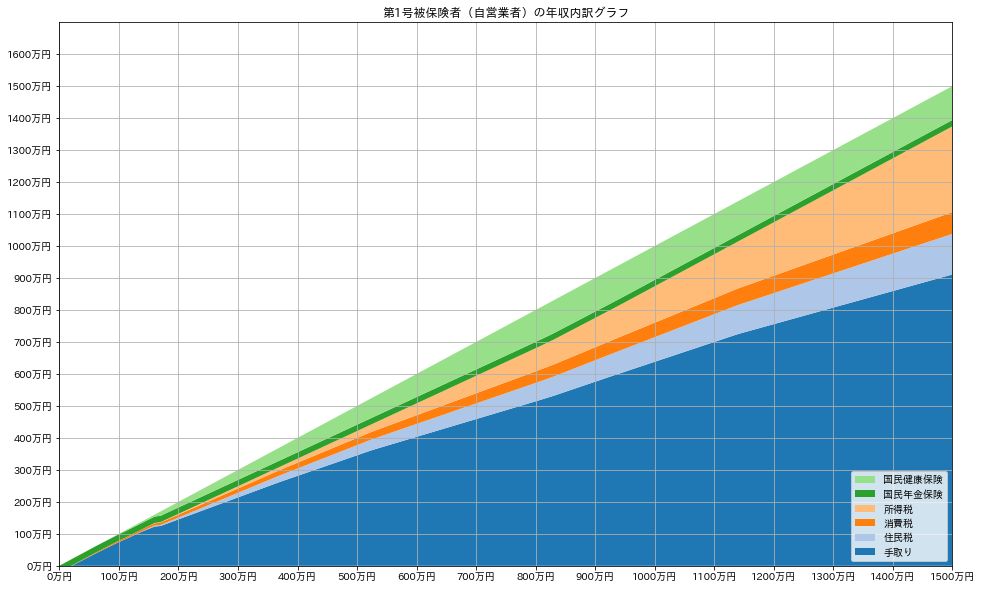

In [6]:
import matplotlib.pyplot as plt

color_list = list(plt.get_cmap("tab20").colors)
labels = ['手取り', '住民税', '消費税', '所得税', '国民年金保険', '国民健康保険']

xticks_indexes = range(年収range.start, 年収range.stop, 1_000_000)
xticks_labels = list(map(lambda x: f'{round(x/10_000)}万円', xticks_indexes))

yticks_indexes = range(年収range.start, 16_000_001, 1_000_000)
yticks_labels = list(map(lambda x: f'{round(x/10_000)}万円', yticks_indexes))

plt.figure(figsize=(16, 10), facecolor='#ffffff')
plt.title('第1号被保険者（自営業者）の年収内訳グラフ')
plt.stackplot(年収内訳df['年収'], 年収内訳df[labels].T, labels=labels, colors=color_list)
plt.xticks(xticks_indexes, xticks_labels)
plt.yticks(yticks_indexes, yticks_labels)
plt.xlim(年収range.start, 年収range.stop)
plt.ylim(0, 17_000_000)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles[::-1],labels=labels[::-1], loc='lower right')
plt.grid()
plt.show()

In [7]:
# 売上1000万円の内訳
年収内訳df[年収内訳df['年収']==10_000_000].drop(columns='国民年金保険内訳').T

,100
年収,10000000
国民健康保険,1060000
国民年金保険,199490
所得税,1137700
消費税,454400
住民税,768500
手取り,6379910


In [8]:
# 売上1000万円の国民年金保険内訳
年収内訳df[年収内訳df['年収']==10_000_000].iloc[0]['国民年金保険内訳']

,0,1
0,医療分,650000
1,後期高齢者支援金分,240000
2,介護分,170000
3,合計,1060000
